<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_WMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-tw36fbvn
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-tw36fbvn
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dfd9739e4bdcce166dc6326afcde41af9a5f8641_-cp36-none-any.whl size=119874 sha256=6b9ffed984da3261785a7ad6516f72bcdd116bd005266874d9ce8e2fa8179e91
  Stored in directory: /tmp/pip-ephem-wheel-cache-cntkqk7t/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [152]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/WMT/df_WMT_20drtn_features.csv')

In [153]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,53.496077,48.176372,52.037396,56.793829,-67.659625,-62.109348,-42.627355,-18.794330,66.162529,58.124789,64.009915,66.601187,0.867811,0.180397,-1.420121,0.381600,2.355105,0.074961,0.125196,0.130396,0.065011,0.269021,0.269021,0.269021,0.269021,121.687810,-22.934779,-2.701761,8.412343,31.169404,21.742991,0.236364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194373,0.023701,0.201941,-0.037363,0.246672,-0.005713,27.549999,2.949999,4.019999,1.582706e+06,1.582706e+06,1.582706e+06,1.582706e+06,0.145182,0.030892,0.105183,0.110970,0.196636,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,51.089830,43.830586,55.227423,57.941008,-71.063798,-65.234268,-51.702737,-19.739933,66.841526,63.942983,63.118843,66.574776,-0.160060,0.060162,0.625129,-0.140083,0.120388,0.057616,0.115262,0.125666,0.066286,0.238834,0.238834,0.238834,0.238834,89.220546,-22.570001,3.271720,13.700570,29.420361,23.972244,0.207548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193756,0.000819,0.188533,-0.035864,0.242417,-0.014181,27.490000,-0.059999,0.949999,4.059189e+05,4.059189e+05,4.059189e+05,4.059189e+05,0.054350,0.022282,0.009129,0.075235,-0.115208,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,38.991071,40.994710,44.918631,53.865175,-92.832796,-92.832796,-84.210576,-32.151318,56.800982,64.243109,62.878088,63.939017,-2.104214,-1.412716,-2.084588,-2.940599,0.184578,0.030184,0.101361,0.118781,0.067132,0.128700,0.128700,0.128700,0.128700,-142.409836,-123.688211,-141.119465,-116.154967,26.386558,24.563237,0.154411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214793,0.027784,0.187582,-0.035497,0.236016,-0.018739,29.379999,1.889999,3.099998,-8.243267e+06,-8.243267e+06,-8.243267e+06,-8.243267e+06,-0.098790,-0.006265,0.013504,0.041198,-0.000863,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,50.564209,56.042503,57.359429,53.804372,-45.051179,-45.051179,-45.051179,-15.602835,56.212801,64.883507,63.449372,66.582696,2.865919,0.540217,0.761983,-2.237357,1.310487,0.016301,0.090746,0.112849,0.067935,0.152627,0.152627,0.152627,0.152627,51.153692,-2.653885,-3.758569,20.920775,22.953158,25.018677,0.835295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.239846,0.053782,0.204962,-0.004547,0.243421,-0.008001,26.360001,-3.019999,0.840000,7.736696e+06,7.736696e+06,7.736696e+06,7.736696e+06,-0.133903,0.064610,0.013382,0.075404,0.165646,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,39.975821,54.362818,53.548502,55.331636,-40.217382,-43.685961,-43.685961,-23.357644,55.563592,71.228370,63.683167,68.633738,0.079604,0.781562,1.493444,-2.216604,0.079604,0.011419,0.082764,0.107745,0.068697,0.172825,0.172825,0.172825,0.172825,79.351476,71.443565,30.194227,56.035656,19.390737,25.425027,0.448719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.239916,0.050696,0.199695,-0.007830,0.243345,-0.005522,27.219999,0.859999,2.619999,5.508122e+06,5.508122e+06,5.508122e+06,5.508122e+06,-0.216974,0.030416,-0.004521,0.055503,-0.073392,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [154]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [155]:
from_date='2010-01-01'
to_date='2020-01-01'

In [156]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [157]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,61.068697,41.105950,45.252615,61.426046,-56.321882,-41.525461,-48.698961,-31.890700,67.977494,37.122180,41.150516,56.543099,-0.995761,-1.123390,-0.537238,1.589404,-1.014017,-0.018244,0.036563,0.091017,0.101683,0.113429,0.113429,0.113429,0.113429,-70.015294,15.064302,31.863592,-25.275440,2.648913,11.279038,0.193547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143627,0.019402,0.143797,0.027077,0.122972,-0.004557,19.350000,-0.690001,-0.580000,-1.087149e+05,-1.087149e+05,-1.087149e+05,-1.087149e+05,-0.052397,-0.003486,0.015950,0.107280,-0.245973,3.695,-0.091,-0.092,0.090004,-0.009995,1.0
446,2010-01-06,59.028975,40.756907,45.823300,58.387407,-77.464781,-46.610168,-53.159890,-41.304357,55.875477,37.606436,36.515779,54.310420,-0.223503,0.224507,-0.997969,0.318349,-2.475879,-0.016197,0.031999,0.084994,0.101039,0.085794,0.085794,0.085794,0.085794,-90.653720,-51.369185,0.135020,-50.249850,-0.161489,8.419949,0.365854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135765,0.022431,0.135139,0.018002,0.123195,0.002529,19.160000,-0.190001,-0.850000,-5.731601e+05,-5.731601e+05,-5.731601e+05,-5.731601e+05,-0.153819,0.005423,-0.036004,0.079982,-0.200097,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,53.004882,45.612849,41.062310,58.623016,-75.352188,-45.339032,-52.044693,-44.744771,45.134273,38.534015,37.301203,51.998794,0.055999,-1.161721,-1.289136,0.487436,-1.488699,-0.016185,0.027357,0.079033,0.100253,0.065559,0.065559,0.065559,0.065559,-90.277995,-76.681585,-10.255886,-55.151105,-1.891491,6.199199,0.693875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135515,0.021459,0.131664,0.014597,0.118195,0.000189,19.059999,-0.100000,-0.900000,-2.754841e+05,-2.754841e+05,-2.754841e+05,-2.754841e+05,-0.042328,-0.028228,-0.013220,0.062763,-0.148156,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,49.447541,43.947831,42.395212,55.028070,-81.212012,-56.779583,-62.081748,-60.481045,43.996048,39.776524,37.521842,49.441780,-0.503725,-0.670510,-0.224507,0.018759,-1.368592,-0.020208,0.021828,0.072765,0.099278,0.027419,0.027419,0.027419,0.027419,-104.696248,-139.256964,-54.854133,-85.075836,-3.427917,4.023883,0.607848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138368,0.012792,0.131058,0.002282,0.118306,-0.005522,18.129999,-0.930000,-3.550001,-1.206331e+06,-1.206331e+06,-1.206331e+06,-1.206331e+06,0.031181,0.045965,-0.014422,0.050707,0.065696,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,60.860021,58.224414,51.199508,56.994918,-27.878771,-19.491513,-29.368079,-31.654729,48.603649,47.857322,38.444969,48.595539,1.650098,1.194697,-0.036881,1.138061,-0.877673,-0.016142,0.019101,0.067795,0.098334,0.067425,0.067425,0.067425,0.067425,101.241638,28.571177,60.013512,13.261074,-3.554578,3.230148,0.828359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160030,0.031585,0.138255,-0.001723,0.121240,-0.005232,17.549999,-0.580000,-2.490002,3.298825e+06,3.298825e+06,3.298825e+06,3.298825e+06,0.098328,0.101334,0.003791,0.027992,0.230965,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [158]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,63.656384,60.692045,56.104940,51.910229,-50.974925,-38.936171,-38.936171,-59.532153,55.433548,49.207400,54.875215,62.140152,0.174883,-0.816291,0.000000,0.425782,0.358752,0.046130,0.027130,0.030192,0.074761,0.343407,0.343407,0.343407,0.343407,28.473026,81.045837,105.462130,152.748418,4.860631,5.037017,0.128573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.085495,0.013507,0.076132,-0.019601,0.107747,0.003467,12.51,0.010000,-0.120000,3.236982e+05,3.236982e+05,3.236982e+05,3.236982e+05,-0.303192,0.003597,-0.043255,-0.087108,0.781860,0.389,0.014,0.093,0.290001,0.540001,0.0
2891,2019-12-23,42.947698,49.088714,45.596060,49.801594,-86.072439,-65.744701,-65.744701,-74.269028,55.798488,49.961915,50.649258,61.575843,-1.047470,-0.692476,-1.252698,-0.276476,-0.276476,0.042245,0.027397,0.030039,0.073455,0.245169,0.245169,0.245169,0.245169,-121.983477,-55.499958,-9.895247,3.498239,4.529597,4.799279,0.011903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100361,0.028223,0.083821,0.005041,0.111065,0.007819,12.61,0.099999,0.469999,-1.668240e+06,-1.668240e+06,-1.668240e+06,-1.668240e+06,-0.348132,-0.120694,-0.055131,-0.112708,-0.436061,0.415,0.026,0.048,-0.029999,0.610001,0.0
2892,2019-12-27,55.016756,55.738713,52.132776,55.086680,-79.810782,-70.473638,-53.829871,-67.719345,65.656350,57.872968,51.598956,62.555235,0.058567,0.470468,-0.408066,-0.141955,0.698884,0.024444,0.024056,0.027813,0.069417,0.146683,0.146683,0.146683,0.146683,-26.210132,-66.438183,-34.336753,9.433239,6.673290,7.064446,0.492747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096311,-0.000457,0.082429,0.003570,0.100134,-0.007704,13.43,0.780001,0.850000,-2.438254e+05,-2.438254e+05,-2.438254e+05,-2.438254e+05,-0.289542,-0.184843,-0.043256,-0.091530,-0.160945,0.356,-0.014,-0.019,-0.669998,-0.490005,0.0
2893,2019-12-30,46.471912,54.509975,53.412788,52.785843,-85.804298,-75.765967,-57.872310,-72.048181,57.275830,52.621269,48.345623,63.105940,-0.158872,-0.092043,-0.739878,-0.739878,0.260312,0.018161,0.022067,0.026626,0.068034,0.111836,0.111836,0.111836,0.111836,-33.109248,-71.066456,-51.441101,-8.975493,6.333034,6.813271,0.397065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093030,0.007535,0.082188,0.006056,0.098425,-0.009322,14.82,1.389999,2.320000,-3.491125e+05,-3.491125e+05,-3.491125e+05,-3.491125e+05,-0.385435,-0.259591,-0.022340,-0.085807,-0.168792,0.405,0.049,0.016,-0.180000,-0.680000,0.0
2894,2019-12-31,36.182685,43.484020,48.525899,53.407351,-83.460716,-83.460716,-69.787302,-78.795235,45.824912,52.563085,48.736149,61.003298,-0.469016,-0.568943,-0.159626,-1.410324,-0.368882,0.009292,0.018880,0.024854,0.066575,0.038586,0.038586,0.038586,0.038586,-166.666667,-105.425588,-102.809613,-68.155200,5.260254,5.904083,0.403723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093519,-0.006841,0.083729,-0.000092,0.099026,-0.012039,13.78,-1.040000,1.270000,-1.149657e+06,-1.149657e+06,-1.149657e+06,-1.149657e+06,-0.321187,-0.239537,-0.085921,-0.090780,0.667459,0.414,0.009,-0.001,-0.349998,-1.320000,0.0


In [159]:
df.drop(['timestamp'], inplace=True, axis=1)

In [160]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [161]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,80.086444,59.929257,54.161836,39.169969,-1.666514,-1.666514,-27.872819,-61.224454,55.330703,59.609496,54.979172,45.294278,1.369651,1.588536,3.471572,3.374139,3.099082,-0.084877,-0.217205,-0.259399,-0.206811,-0.542833,-0.542833,-0.542833,-0.542833,162.721988,197.144928,208.127219,172.191261,-41.403078,-52.068836,0.935903,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.126308,0.021178,0.207133,0.002033,0.243044,0.000300,19.540001,-1.400000,-8.089998,3.133289e+06,3.133289e+06,3.133289e+06,3.133289e+06,0.320228,0.122571,0.138885,0.013345,-0.110630,2.048,6.700003e-02,-0.034,0.279999,0.080002,0.0
2747,43.766278,48.475570,46.574174,54.765451,-55.577221,-55.577221,-57.169755,-33.114735,46.693018,40.952670,47.672350,58.835276,-0.394005,-0.187538,0.827602,-0.177690,-1.891915,-0.039141,0.028220,0.062082,0.068864,0.072771,0.072771,0.072771,0.072771,6.148169,41.876573,6.077922,-42.226988,3.201905,6.202280,0.576001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200124,-0.005462,0.178444,0.006298,0.146539,0.000996,14.950000,-1.360000,-3.110000,1.495253e+06,1.495253e+06,1.495253e+06,1.495253e+06,-0.022795,-0.052551,0.040317,0.088584,-0.042396,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,69.390333,76.912213,77.538029,59.898823,-23.275795,-21.485344,-12.796174,-10.099720,75.857136,73.371604,76.719972,69.044365,-1.141671,0.775882,0.404082,3.047246,10.115607,0.430703,0.307633,0.202125,0.023243,1.283073,1.283073,1.283073,1.283073,37.202385,75.376576,92.299204,102.018358,83.871878,81.280429,0.208794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162331,0.000348,0.154611,-0.010155,0.174281,0.001239,24.530001,-0.929998,-6.789999,8.135254e+05,8.135254e+05,8.135254e+05,8.135254e+05,0.069933,0.069998,0.101443,-0.006051,-0.263137,2.296,-8.899999e-02,0.108,0.219994,-1.210007,1.0
765,68.652950,69.472082,65.504044,50.135865,-15.976371,-13.043502,-12.328796,-9.030122,70.645831,72.458225,66.354022,54.814318,0.637301,0.261437,0.111873,1.340127,3.969789,0.121494,0.030114,-0.035007,-0.050141,0.233884,0.233884,0.233884,0.233884,139.049407,111.518176,114.586154,133.470509,17.067581,11.547796,0.161287,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.096641,-0.007291,0.103576,-0.002203,0.104646,-0.032538,15.070000,-0.760000,-1.850000,8.619810e+05,8.619810e+05,8.619810e+05,8.619810e+05,0.066171,0.018478,0.013869,-0.052497,0.203813,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,41.260888,37.358203,40.691943,59.503379,-63.722328,-64.615338,-68.319560,-44.991782,33.119831,23.588672,22.996894,56.712138,0.540840,1.017143,0.276621,-1.226160,-3.307553,-0.096250,0.053017,0.147158,0.230439,-0.038523,-0.038523,-0.038523,-0.038523,162.743062,4.203100,-30.822714,-53.449877,6.559526,13.265743,0.597222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193196,0.017341,0.147932,-0.019414,0.150311,-0.006263,16.350000,1.170000,2.330000,2.791774e+05,2.791774e+05,2.791774e+05,2.791774e+05,0.014378,-0.080769,-0.164573,0.159603,0.111135,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [162]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [163]:
train_labels.head()

1856    0.0
2747    1.0
898     1.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [164]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [165]:
get_sample_weights(train_labels)

real class weights are [1.20098039 0.85664336] [0 1]
value_counts (array([0, 1]), array([ 816, 1144]))


1856    1.200980
2747    0.856643
898     0.856643
765     0.856643
1100    0.856643
          ...   
2051    0.856643
1301    0.856643
2192    0.856643
1640    0.856643
2882    1.200980
Name: labels, Length: 1960, dtype: float64

In [166]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.20098039 0.85664336] [0 1]
value_counts (array([0, 1]), array([ 816, 1144]))


In [167]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [168]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [169]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=30
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_15',
 'mfi_15',
 'mfi_40',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'kst_20',
 'kst_40',
 'ibr',
 'bb_h15',
 'bb_l15',
 'bb_h20',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'vix_level',
 'vix_1d_change',
 'vix_5d_change',
 'cmf_10',
 'cmf_15',
 'cmf_20',
 'cmf_40',
 'curve',
 'curve_shift',
 'curve_shift_5d')

In [170]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_40',
 'wr_10',
 'wr_20',
 'wr_40',
 'mfi_10',
 'mfi_15',
 'roc_3',
 'trix_10',
 'trix_15',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_10',
 'kst_20',
 'ibr',
 'bb_l10',
 'bb_h20',
 'bb_h40',
 'realised_vol_10',
 'realised_vol_change_5d_10',
 'realised_vol_20',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'cmf_15',
 'curve',
 'curve_shift_5d',
 'dollarix_5d_change')

In [171]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_40,wr_10,wr_20,wr_40,mfi_10,mfi_15,roc_3,trix_10,trix_15,macd10,macd15,macd20,macd40,cci_10,kst_20,ibr,bb_l10,bb_h20,bb_h40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,cmf_15,curve,curve_shift_5d,dollarix_5d_change
445,0.879587,-0.343262,-0.137752,0.373183,0.898308,-0.939992,-0.675692,-0.275106,0.022328,-0.086257,-0.086257,-0.086257,-0.086257,0.016458,-0.152645,-1.058335,-0.207572,-0.289876,-0.297051,-0.098565,0.261475,-0.202913,0.607383,-0.696685,-0.177399,0.445087,-0.020227,2.013397,-0.791371,-0.049440
448,0.242226,-1.177195,-0.578212,-0.551652,-0.426110,-0.767055,-0.427807,-0.285373,-0.071483,-0.183188,-0.183188,-0.183188,-0.183188,-1.454846,-0.304924,0.347827,-0.207572,-0.289876,-0.297051,-0.161413,0.174033,-0.384982,0.055825,-0.778767,-0.215760,0.226020,0.259783,2.093196,-0.164259,-0.484604
452,0.084299,0.022238,0.337596,0.296667,-0.293372,0.042360,-0.060802,-0.002572,-0.027956,0.023568,0.023568,0.023568,0.023568,0.547040,-0.270119,-1.465686,-0.207572,-0.289876,-0.297051,0.366125,0.626498,-0.139393,0.373826,-0.588067,0.439389,0.136238,0.555158,2.006838,-0.753933,-1.389278
469,-0.490942,-0.560778,-0.920794,-0.777862,-0.448745,-1.019661,0.228528,-0.420217,-0.412463,-0.354932,-0.354932,-0.354932,-0.354932,-0.615202,-0.477089,0.109066,-0.207572,-0.289876,-0.297051,0.612976,0.506246,0.312066,0.524417,-0.074175,0.471760,1.639183,-1.483866,1.836308,-0.042583,0.935386
470,-0.688895,-0.577612,-0.933027,-0.789053,-0.528575,-0.706508,-0.275851,-0.420395,-0.421366,-0.355636,-0.355636,-0.355636,-0.355636,-0.528160,-0.501149,0.044652,-0.207572,-0.289876,-0.297051,0.602886,0.276130,0.251788,0.323985,-0.074115,0.294610,1.531445,-1.760043,1.902990,-0.108102,0.717803


In [172]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [173]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [174]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.5636568 , 0.43634316],
       [0.5184161 , 0.48158392],
       [0.4958126 , 0.5041874 ],
       [0.4487353 , 0.5512647 ],
       [0.5166905 , 0.4833095 ],
       [0.6075291 , 0.3924709 ],
       [0.55949867, 0.44050136],
       [0.5145261 , 0.48547384],
       [0.5280106 , 0.47198942],
       [0.46458673, 0.53541327]], dtype=float32)

In [175]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
79/79 [==============================] - ETA: 0s - loss: 0.7416 - accuracy: 0.4860
Epoch: 0, accuracy:0.4860,  loss:0.7416,  val_accuracy:0.5791,  val_loss:0.6921,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7416 - accuracy: 0.4860 - val_loss: 0.6921 - val_accuracy: 0.5791
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7070 - accuracy: 0.5236 - val_loss: 0.6922 - val_accuracy: 0.5204
Epoch 3/200
79/79 [==============================] - 0s 6ms/step - loss: 0.7027 - accuracy: 0.5108 - val_loss: 0.6878 - val_accuracy: 0.5714
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5230 - val_loss: 0.6850 - val_accuracy: 0.5842
Epoch 5/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.5466 - val_loss: 0.6797 - val_accuracy: 0.5689
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6854 - accuracy: 0.5472 - val_loss: 0.6707 - val_accur

In [176]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.374815,0.841199,0.538575,0.788265,195
196,0.353709,0.847577,0.537250,0.775510,196
197,0.354558,0.847577,0.576852,0.765306,197
198,0.368819,0.830995,0.568840,0.770408,198
199,0.374169,0.835459,0.533504,0.760204,199


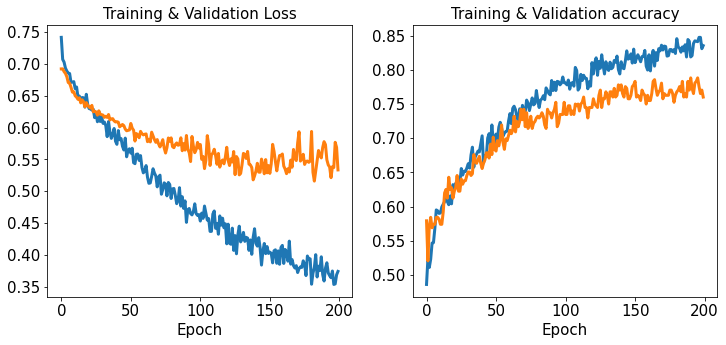

In [177]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [124]:
!pip install shap

In [178]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [179]:
shap_values  = explainer.shap_values(np.array(X_test_new))

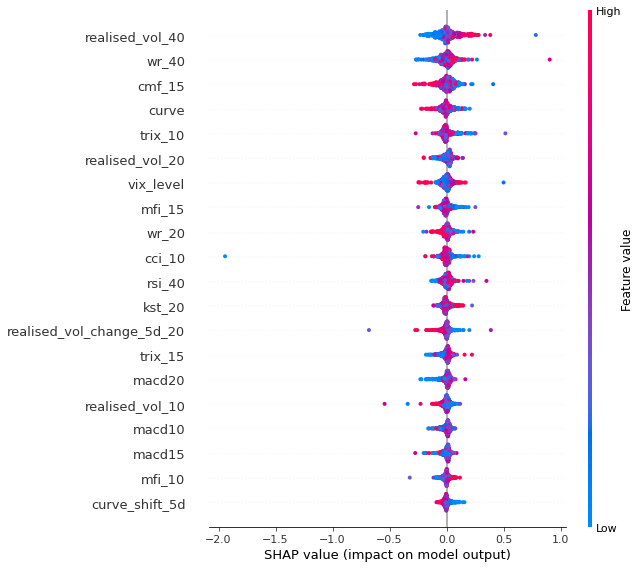

In [180]:
shap.summary_plot(shap_values[1], X_test_new)

In [181]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [182]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


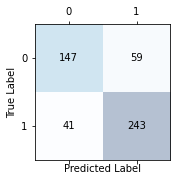

In [183]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [184]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.805
Recall: 0.856
F1: 0.829


In [185]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [186]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [187]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [10,20,25,30],
  }
]

In [188]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [189]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [190]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [191]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 30.9min finished


In [192]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/JNJ/xgb_JNJ_log_reg.pickle', "wb"))

In [193]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9366693986157353
Accuracy: 0.8306122448979592


Confusion Matrix


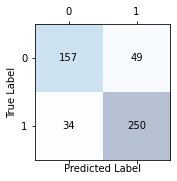

In [194]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [199]:
print(model.best_params_)

AttributeError: ignored

In [197]:
model = xgb.XGBClassifier(max_depth=8,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.0)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.252041	validation_0-logloss:0.66444	validation_1-error:0.387755	validation_1-logloss:0.679456
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.194898	validation_0-logloss:0.637704	validation_1-error:0.37551	validation_1-logloss:0.667119
[2]	validation_0-error:0.167857	validation_0-logloss:0.619464	validation_1-error:0.346939	validation_1-logloss:0.658787
[3]	validation_0-error:0.141837	validation_0-logloss:0.599001	validation_1-error:0.295918	validation_1-logloss:0.648281
[4]	validation_0-error:0.135714	validation_0-logloss:0.584608	validation_1-error:0.302041	validation_1-logloss:0.643395
[5]	validation_0-error:0.117347	validation_0-logloss:0.569322	validation_1-error:0.318367	validation_1-logloss:0.638329
[6]	validation_0-error:0.1	validation_0-logloss:0.552323	validation_1-error:0.306122	validation_1-logloss:0.632378
[7

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [198]:

# make predictions for test data
y_pred = model.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.10%


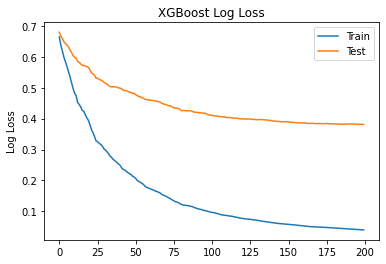

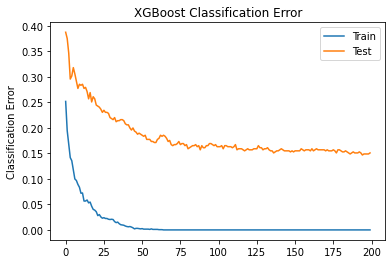

In [200]:
from matplotlib import pyplot

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [201]:
shap_values = shap.TreeExplainer(model).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


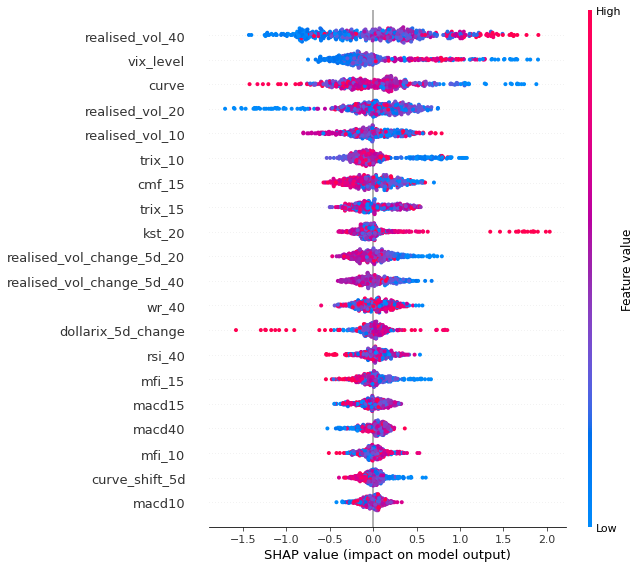

In [202]:
shap.summary_plot(shap_values, X_test_new)

In [203]:
predict = model.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


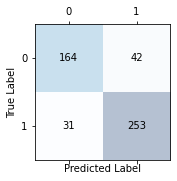

In [204]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()